In [286]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
# Apply the default theme
sns.set_theme()

import os
from pathlib import Path
import itertools

from data import name_to_dataset

RESULTS_PATH = 'results/'
AGREE_PATH = os.path.join(RESULTS_PATH, 'agree')
ERRORS_PATH = os.path.join(RESULTS_PATH, 'errors')

MODELS = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree',
    'RandomForest2',
    'RandomForest4',
    'RandomForest8',
    'RandomForest16',
    'RandomForest',
    'XGBoost',
    'MLP'
    ]
# LogisticRegressionSGD

DATASETS = [
    'adult',
    'communities',
    'compas',
    'german',
    'incomeCA',
    'incomeNY',
    'incomeTX',
    'employmentCA',
    'employmentNY',
    'employmentTX',
    'coverageCA',
    'coverageNY',
    'coverageTX'
    ]

In [324]:
# Some setup for Folktables datasets
GROUPS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
FOLK_RACE_GROUPS = [1, 2, 3, 4, 5, 6, 7]
FOLK_SEX_GROUPS = [8, 9]
FOLK_AGE_GROUPS = [10, 11]

RACE_SEX_INTERSECTIONS = list(itertools.product(FOLK_RACE_GROUPS, FOLK_SEX_GROUPS))
RACE_SEX_INTERSECTIONS = [str(pair).replace(" ", "") for pair in RACE_SEX_INTERSECTIONS]

RACE_AGE_INTERSECTIONS = list(itertools.product(FOLK_RACE_GROUPS, FOLK_AGE_GROUPS))
RACE_AGE_INTERSECTIONS = [str(pair).replace(" ", "") for pair in RACE_AGE_INTERSECTIONS]

AGE_SEX_INTERSECTIONS = list(itertools.product(FOLK_AGE_GROUPS, FOLK_SEX_GROUPS))
AGE_SEX_INTERSECTIONS = [str(pair).replace(" ", "") for pair in AGE_SEX_INTERSECTIONS]

ALL_INTERSECTIONS = list(itertools.product(["ALL"], GROUPS))
ALL_INTERSECTIONS = [str(pair).replace(" ", "") for pair in ALL_INTERSECTIONS]

# Agreement Data

In [287]:
def load_agree_results(dataset, model):
    dataset_obj = name_to_dataset(dataset)
    path = os.path.join(os.path.join(AGREE_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = dataset_obj.group_names
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    return_dict['intersections'] = dataset_obj.intersections
    raw_results = torch.load(path)

    # Convert format of results
    results = {}
    errs = {}
    result_names = []
    for (g1, g2) in dataset_obj.intersections:
        key = "({},{})".format(groups[g1], groups[g2])
        new_key = "({},{})".format(g1, g2)
        result_names.append(key)
        results[new_key] = raw_results[key][0]
        errs[new_key] = raw_results[key][1]
    for i, g in enumerate(groups[1:]):
        key = "(ALL, {})".format(g)
        new_key = "(ALL,{})".format(i + 1)
        result_names.append(key)
        results[new_key] = raw_results[key][0]
        errs[new_key] = raw_results[key][1]

    return_dict['result_names'] = result_names
    return_dict['results'] = results
    return_dict['std_errs'] = errs
    return return_dict

In [288]:
def model_agree_df(model, datasets, intersections):
    """
    Creates a dataframe for each fixed model with the agreement data for each dataset. Columns are the intersections, rows are the datasets.
    """
    rows = datasets
    cols = intersections
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for dataset in datasets:
        results = load_agree_results(dataset, model)
        name = results['name']
        df.loc[name] = results['results']
        df_errs.loc["{}_err".format(name)] = results['std_errs']

    df = pd.concat([df, df_errs])
    return df

def dataset_agree_df(models, dataset, intersections):
    """
    Creates a dataframe for each fixed dataset with the agreement data for each model. Columns are the intersections, rows are the models.
    """
    rows = models
    cols = intersections
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for model in models:
        results = load_agree_results(dataset, model)
        df.loc[model] = results['results']
        df_errs.loc["{}_err".format(model)] = results['std_errs']

    df = pd.concat([df, df_errs])
    return df

In [290]:
# Dataframe 1: Fixed model, rows=datasets, cols=intersections
small_datasets = DATASETS[:4]
small_dataset_intersections = ["(1,3)", "(1,4)", "(2,3)", "(2,4)", 
                         "(ALL,1)", "(ALL,2)", "(ALL,3)", "(ALL,4)"]
big_datasets = DATASETS[4:]
big_dataset = load_agree_results(big_datasets[0], MODELS[0])
big_intersections = big_dataset['intersections']
big_groups = big_dataset['groups']
big_dataset_intersections = [str(inter).replace(" ", "") for inter in big_intersections]
for g in range(1, len(big_groups)):
    big_dataset_intersections.append("(ALL,{})".format(g))

# Create a DF for each model
DF_PATH = os.path.join(AGREE_PATH, 'dfs')
fixed_model_dir = os.path.join(DF_PATH, 'fixed_model')
Path(fixed_model_dir).mkdir(parents=True, exist_ok=True)
small_model_dfs_agree = {}
big_model_dfs_agree = {}
for model in MODELS:
    small_path = os.path.join(fixed_model_dir, "{}_small.csv".format(model))
    try:
        small_model_dfs_agree[model] = pd.read_csv(small_path, index_col=0)
    except FileNotFoundError:
        small_model_dfs_agree[model] = model_agree_df(model, small_datasets,
                                                small_dataset_intersections)
        small_model_dfs_agree[model].to_csv(small_path)
    big_path = os.path.join(fixed_model_dir, "{}_big.csv".format(model))
    try:
        big_model_dfs_agree[model] = pd.read_csv(big_path, index_col=0)
    except FileNotFoundError:
        big_model_dfs_agree[model] = model_agree_df(model, big_datasets,
                                            big_dataset_intersections)
        big_model_dfs_agree[model].to_csv(big_path)
        
# Create a DF for each dataset
fixed_dataset_dir = os.path.join(DF_PATH, 'fixed_dataset')
Path(fixed_dataset_dir).mkdir(parents=True, exist_ok=True)
dataset_dfs_agree = {}
for dataset in DATASETS:
    path = os.path.join(fixed_dataset_dir, "{}.csv".format(dataset))
    try:
        raise FileNotFoundError
        dataset_dfs_agree[dataset] = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        if dataset in small_datasets:
            dataset_dfs_agree[dataset] = dataset_agree_df(MODELS, dataset,
                                                small_dataset_intersections)
        else:
            dataset_dfs_agree[dataset] = dataset_agree_df(MODELS, dataset,
                                                    big_dataset_intersections)
        dataset_dfs_agree[dataset].to_csv(path)

## Plot: Agreements for fixed model class

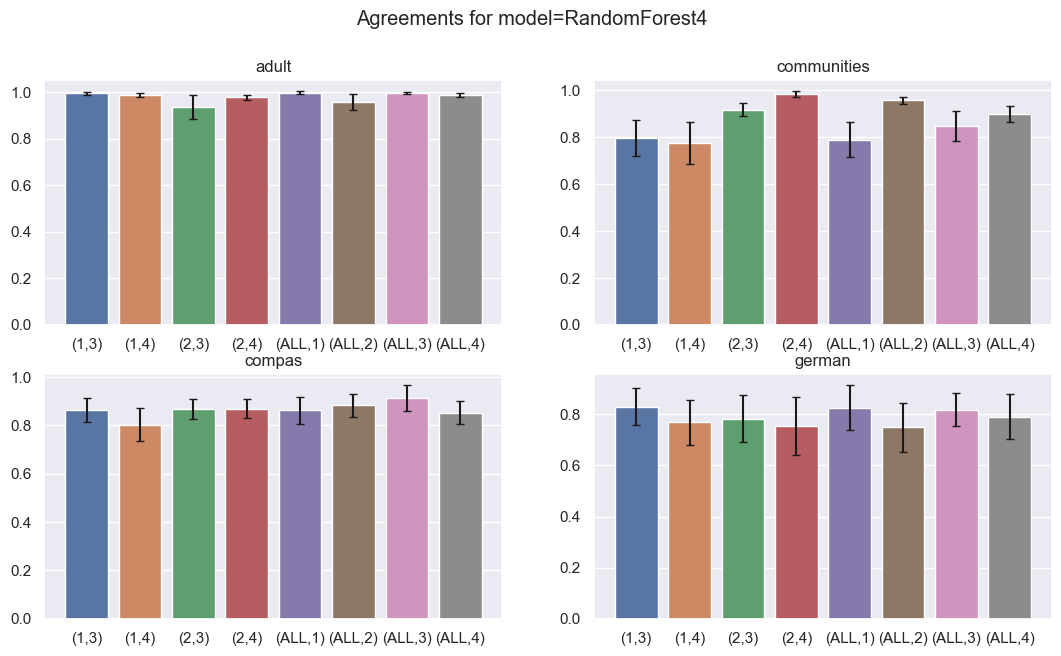

In [291]:
# Plot for each model
# Small datasets
model = MODELS[8]
fig, axs = plt.subplots(2, 2, figsize=(13, 7))
fig.suptitle("Agreements for model={}".format(model))
indices = itertools.product([0, 1], [0, 1])

for dataset, (i,j) in zip(small_datasets, indices):
    data = small_model_dfs_agree[model].loc[dataset]
    errs = small_model_dfs_agree[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i][j], x=data.index, y=data.values)
    axs[i][j].set_title(dataset)
    axs[i][j].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
plt.show()

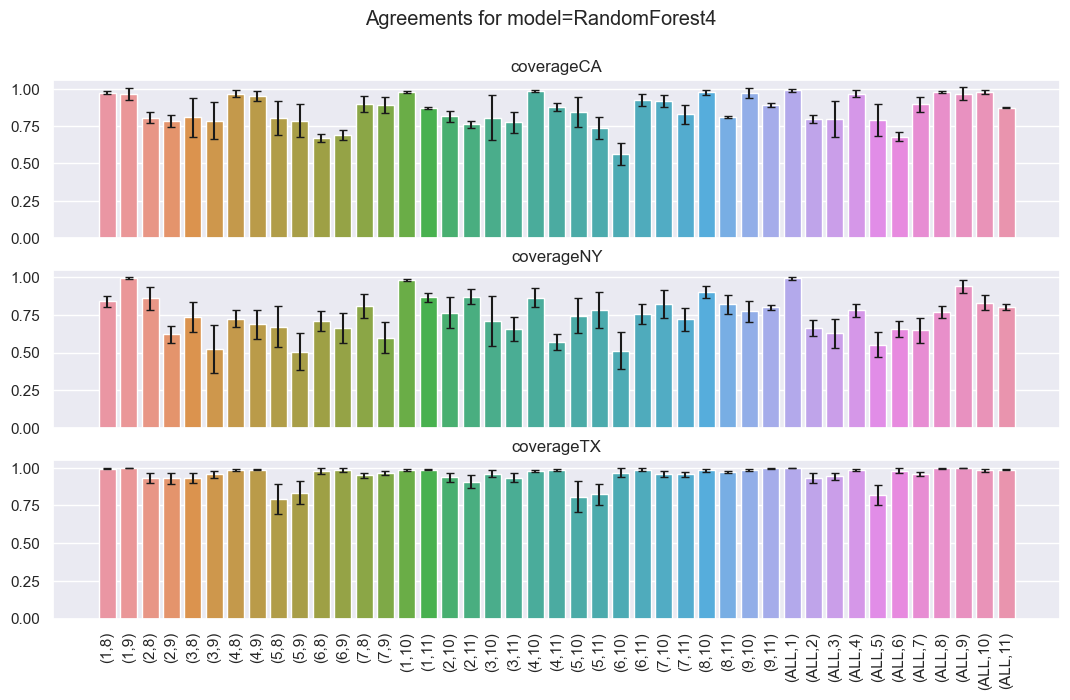

In [292]:
# Large datasets
fig, axs = plt.subplots(3, 1, figsize=(13, 7))
fig.suptitle("Agreements for model={}".format(model))
income_datasets = big_datasets[:3]
employment_datasets = big_datasets[3:6]
coverage_datasets = big_datasets[6:9]

# Income Datasets
plt.xticks(rotation=90)
for i, dataset in enumerate(coverage_datasets):
    data = big_model_dfs_agree[model].loc[dataset]
    errs = big_model_dfs_agree[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i], x=data.index, y=data.values)
    axs[i].set_title(dataset)
    axs[i].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    if i < 2:
        axs[i].set(xticklabels=[])
plt.show()

## Plot: Agreements for fixed dataset

In [293]:
'''
def plot_dataset_agreement(ax, data, models, legend=True):
    bar_width = 0.1
    data = data.transpose() # rows: intersections, cols: models
    intersections = list(data.index)
    index = list(range(len(intersections)))
    ax.set_prop_cycle(color=sns.color_palette()[:len(models)])
    for i, intersection in enumerate(intersections):
        bar_locs = np.linspace(-3, 4, num=len(models))
        for j, model in enumerate(models):
            if i == 0:
                ax.bar(i + bar_locs[j] * bar_width, 
                       data.loc[intersection][model], bar_width,
                       yerr=data.loc[intersection]["{}_err".format(model)],label=model)
            else:
                ax.bar(i + bar_locs[j] * bar_width, 
                       data.loc[intersection][model], bar_width,
                       yerr=data.loc[intersection]["{}_err".format(model)])

    ax.set_xticks(index, intersections)
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True, shadow=True, ncol=4)
    return ax
'''

def plot_agreement(ax, name, data, models, intersections):
    # Preprocess the data into a vertical DF
    rows = []
    for (intersection, model) in itertools.product(intersections, models):
        row = {}
        row['intersection'] = intersection
        row['model'] = model
        row['agreement'] = data.loc[intersection][model]
        err = data.loc[intersection]["{}_err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[intersection][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)
    df['model'] = pd.Categorical(df['model'], models)
    df['intersection'] = pd.Categorical(df['intersection'], intersections)

    # Plot the data
    err = []
    lerr = df.pivot(index='intersection', columns='model', values='lerr')
    uerr = df.pivot(index='intersection', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='intersection', columns='model', values='agreement')
    ax = p.plot(kind='bar', yerr=err, ax=plt.gca())
    ax.set_ylabel('agreement')
    ax.set_title("Agreement for {}".format(name))
    ax.legend(loc='center', frameon=False, bbox_to_anchor=(0, 0.5, 2.25, 0))
    return ax

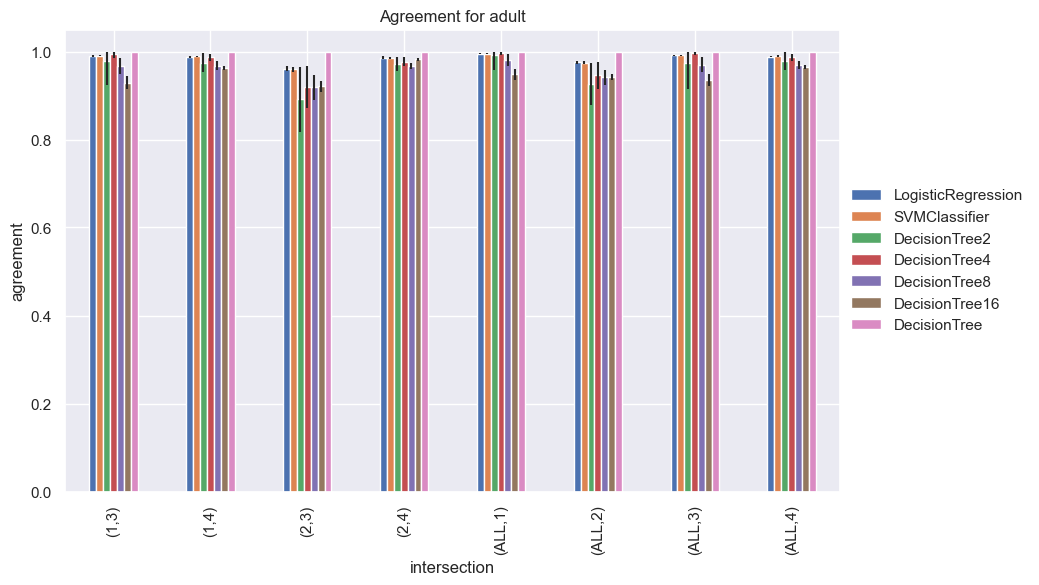

In [294]:
data = dataset_dfs_agree['adult'].transpose()
models = MODELS[:7]
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))

ax = plot_agreement(ax, 'adult', data, models, intersections)
plt.show()

# Error Data

In [295]:
def load_error_results(dataset, model):
    dataset_obj = name_to_dataset(dataset)
    path = os.path.join(os.path.join(ERRORS_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = dataset_obj.group_names
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    raw_results = torch.load(path)

    # Convert format of results
    return_dict['results'] = {}
    for g, group_name in enumerate(dataset_obj.group_names):
        erm_all_results = raw_results[g]['ERM_ALL']
        erm_all_err = erm_all_results[0] - erm_all_results[1][0]
        erm_group_results = raw_results[g]['ERM_GROUP']
        erm_group_err = erm_group_results[0] - erm_group_results[1][0]
        erm_prepend_results = raw_results[g]['PREPEND']
        erm_prepend_err = erm_prepend_results[0] - erm_prepend_results[1][0]

        return_dict['results'][g] = {}
        return_dict['results'][g]['ERM_ALL'] = (erm_all_results[0], erm_all_err)
        return_dict['results'][g]['ERM_GROUP'] = (erm_group_results[0], erm_group_err)
        return_dict['results'][g]['PREPEND'] = (erm_prepend_results[0], erm_prepend_err)
    return return_dict

In [296]:
def model_error_df(model, datasets, groups):
    """
    Creates a dataframe for each fixed model with the error data for each dataset. Columns are the groups and training method, rows are datasets.
    """
    rows = datasets

    # Construct columns
    cols = []
    for g in groups:
        cols.append("{} (ERM)".format(g))
        cols.append("{} (G-ERM)".format(g))
        cols.append("{} (PREP)".format(g))
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for dataset in datasets:
        results = load_error_results(dataset, model)
        name = results['name']
        group_errors = results['results']
        row = []
        err_row = []
        for g in groups:
            row.append(group_errors[g]['ERM_ALL'][0])
            err_row.append(group_errors[g]['ERM_ALL'][1])
            row.append(group_errors[g]['ERM_GROUP'][0])
            err_row.append(group_errors[g]['ERM_GROUP'][1])
            row.append(group_errors[g]['PREPEND'][0])
            err_row.append(group_errors[g]['PREPEND'][1])

        df.loc[name] = row
        df_errs.loc["{}_err".format(name)] = err_row

    df = pd.concat([df, df_errs])
    return df

def dataset_error_df(models, dataset, groups):
    """
    Creates a dataframe for each fixed dataset with the error data for each model. Columns are the groups, rows are the models.
    """
    # Construct columns
    rows = []
    for model in models:
        rows.append("{} (ERM)".format(model))
        rows.append("{} (G-ERM)".format(model))
        rows.append("{} (PREP)".format(model))
    df = pd.DataFrame(index=rows, columns=groups)
    df_errs = pd.DataFrame(columns=groups)

    for model in models:
        results = load_error_results(dataset, model)
        group_errors = results['results']
        erm_row = []
        erm_row_err = []
        germ_row = []
        germ_row_err = []
        prep_row = []
        prep_row_err = []
        for g in groups:
            erm_row.append(group_errors[g]['ERM_ALL'][0])
            erm_row_err.append(group_errors[g]['ERM_ALL'][1])
            germ_row.append(group_errors[g]['ERM_GROUP'][0])
            germ_row_err.append(group_errors[g]['ERM_GROUP'][1])
            prep_row.append(group_errors[g]['PREPEND'][0])
            prep_row_err.append(group_errors[g]['PREPEND'][1])

        df.loc["{} (ERM)".format(model)] = erm_row
        df_errs.loc["{} (ERM) err".format(model)] = erm_row_err
        df.loc["{} (G-ERM)".format(model)] = germ_row
        df_errs.loc["{} (G-ERM) err".format(model)] = germ_row_err
        df.loc["{} (PREP)".format(model)] = prep_row
        df_errs.loc["{} (PREP) err".format(model)] = prep_row_err

    df = pd.concat([df, df_errs])
    return df

In [305]:
# Dataframe 1: Fixed model, rows=datasets, cols=groups
small_datasets = DATASETS[:4]
small_dataset_groups = list(range(len(name_to_dataset(DATASETS[0]).group_names)))
big_datasets = DATASETS[4:]
big_dataset_groups = list(range(len(name_to_dataset(DATASETS[4]).group_names)))

# Create a DF for each model
DF_PATH = os.path.join(ERRORS_PATH, 'dfs')
fixed_model_dir = os.path.join(DF_PATH, 'fixed_model')
Path(fixed_model_dir).mkdir(parents=True, exist_ok=True)
small_model_dfs_error = {}
big_model_dfs_error = {}
for model in MODELS:
    small_path = os.path.join(fixed_model_dir, "{}_small.csv".format(model))
    try:
        small_model_dfs_error[model] = pd.read_csv(small_path, index_col=0)
    except FileNotFoundError:
        small_model_dfs_error[model] = model_error_df(model, small_datasets,
                                                small_dataset_groups)
        small_model_dfs_error[model].to_csv(small_path)
    big_path = os.path.join(fixed_model_dir, "{}_big.csv".format(model))
    try:
        big_model_dfs_error[model] = pd.read_csv(big_path, index_col=0)
    except FileNotFoundError:
        big_model_dfs_error[model] = model_error_df(model, big_datasets,
                                            big_dataset_groups)
        big_model_dfs_error[model].to_csv(big_path)
        
# Dataframe 2: Fixed dataset, rows=models, cols=groups
# Create a DF for each dataset
fixed_dataset_dir = os.path.join(DF_PATH, 'fixed_dataset')
Path(fixed_dataset_dir).mkdir(parents=True, exist_ok=True)
dataset_dfs_error = {}
for dataset in DATASETS:
    path = os.path.join(fixed_dataset_dir, "{}.csv".format(dataset))
    try:
        dataset_dfs_error[dataset] = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        if dataset in small_datasets:
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                small_dataset_groups)
        else:
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                    big_dataset_groups)
        dataset_dfs_error[dataset].to_csv(path)

## Plot: Errors for fixed model class

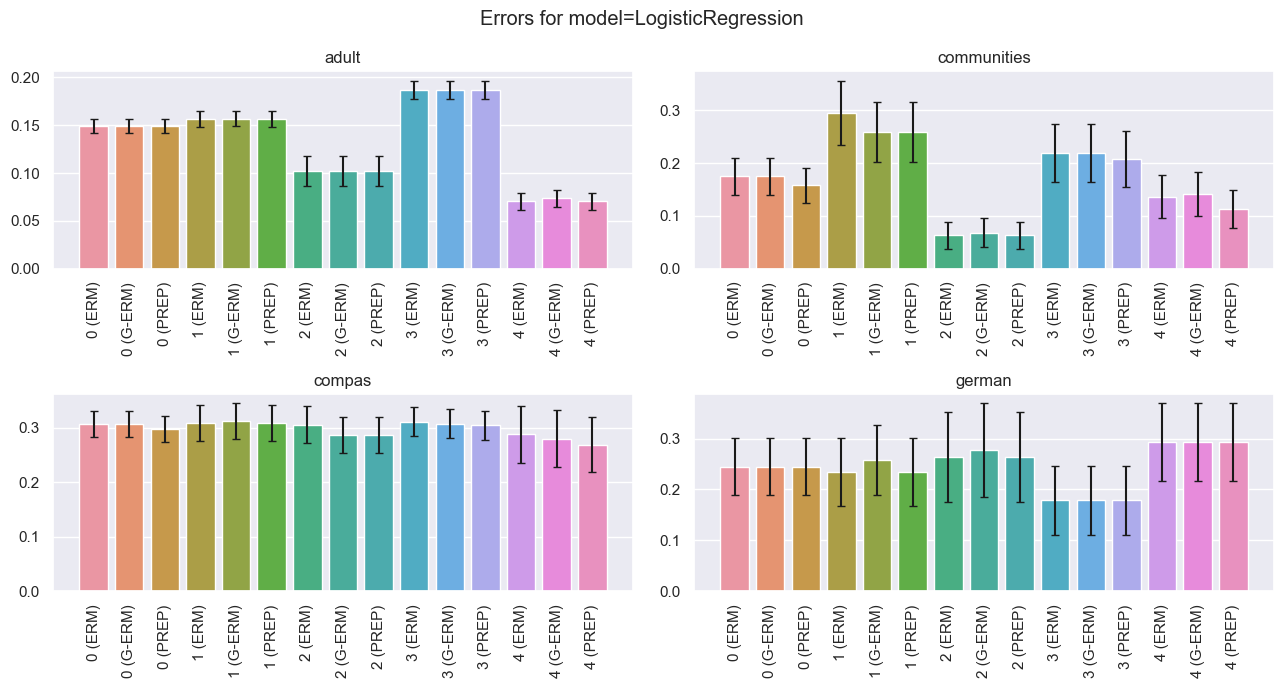

In [306]:
# Plot for each model
# Small datasets
model = MODELS[0]
fig, axs = plt.subplots(2, 2, figsize=(13, 7), )
fig.suptitle("Errors for model={}".format(model))
indices = itertools.product([0, 1], [0, 1])

for dataset, (i,j) in zip(small_datasets, indices):
    data = small_model_dfs_error[model].loc[dataset]
    errs = small_model_dfs_error[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i][j], x=data.index, y=data.values)
    axs[i][j].set_title(dataset)
    axs[i][j].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    axs[i][j].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

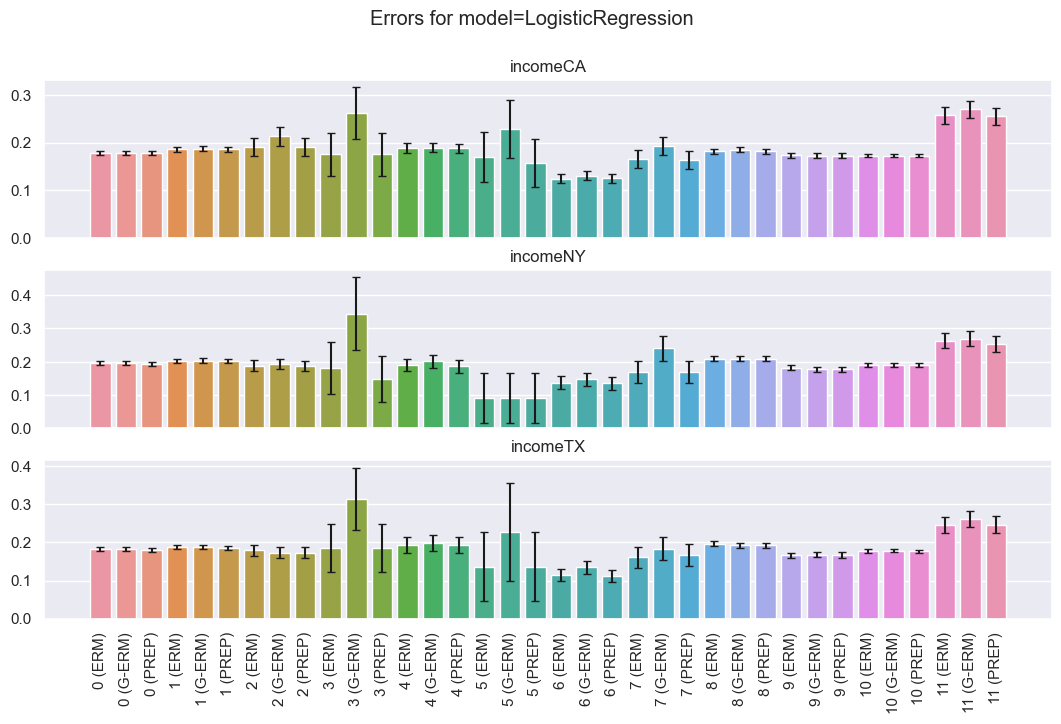

In [307]:
# Large datasets
fig, axs = plt.subplots(3, 1, figsize=(13, 7))
fig.suptitle("Errors for model={}".format(model))
income_datasets = big_datasets[:3]
employment_datasets = big_datasets[3:6]
coverage_datasets = big_datasets[6:9]

plt.xticks(rotation=90)
for i, dataset in enumerate(income_datasets):
    data = big_model_dfs_error[model].loc[dataset]
    errs = big_model_dfs_error[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i], x=data.index, y=data.values)
    axs[i].set_title(dataset)
    axs[i].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    if i < 2:
        axs[i].set(xticklabels=[])
plt.show()

## Plot: Errors for fixed dataset

In [308]:
def plot_error(ax, name, data, models, groups):
    # Preprocess the data into a vertical DF
    rows = []
    for (group, model) in itertools.product(groups, models):
        row = {}
        row['group'] = group
        row['model'] = model
        row['error'] = data.loc[group][model]
        err = data.loc[group]["{} err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[group][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)

    # Plot the data
    err = []
    lerr = df.pivot(index='group', columns='model', values='lerr')
    uerr = df.pivot(index='group', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='group', columns='model', values='error')
    ax = p.plot(kind='bar', yerr=err, ax=plt.gca())
    ax.set_ylabel('test error')
    ax.set_title("Test Errors for {}".format(name))
    ax.legend(loc='center', frameon=False, bbox_to_anchor=(0, 0.5, 2.5, 0))
    return ax

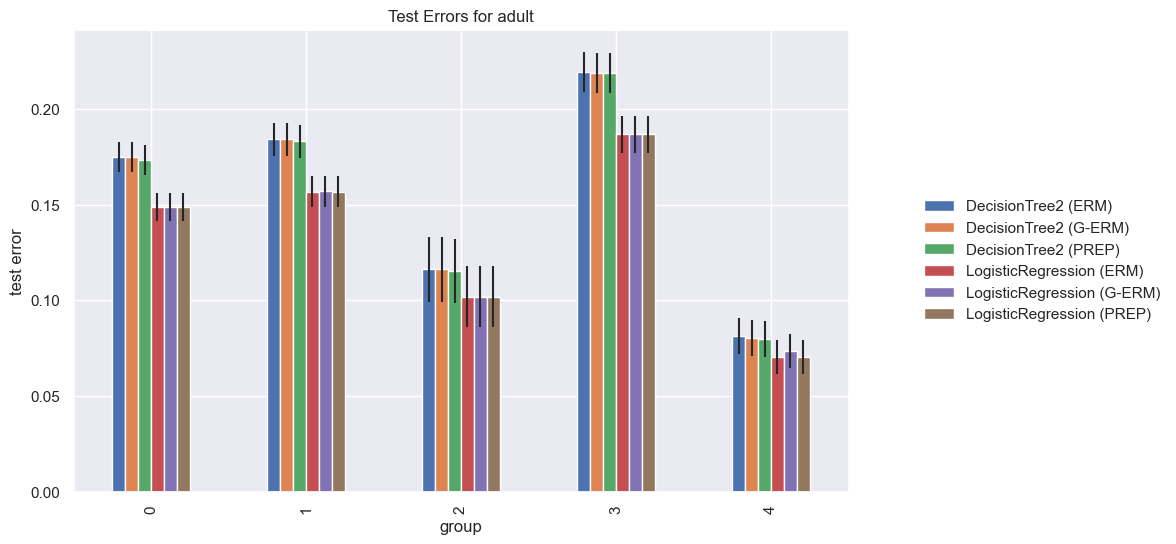

In [311]:
data = dataset_dfs_error['adult'].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 'LogisticRegression (G-ERM)', 'LogisticRegression (PREP)', 'DecisionTree2 (ERM)', 'DecisionTree2 (G-ERM)', 'DecisionTree2 (PREP)']
fig, ax = plt.subplots(figsize=(10, 6))

ax = plot_error(ax, 'adult', data, models, groups)

# Final Plots

## Display 1: Agreement by varying model complexity
The first set of plots we show is that agreement goes up as we vary model
complexity. Of course, we'd expect this to be the case with Random Forests and
Decision Trees, but sometimes we get high agreement even with Logistic Regression
or (linear) SVM. This suggests that the multi-group setting for these datasets
with high agreement with linear models should be easy.

### Plot 1A: All model types
In this plot, we go through all the models from parametric to nonparametric.

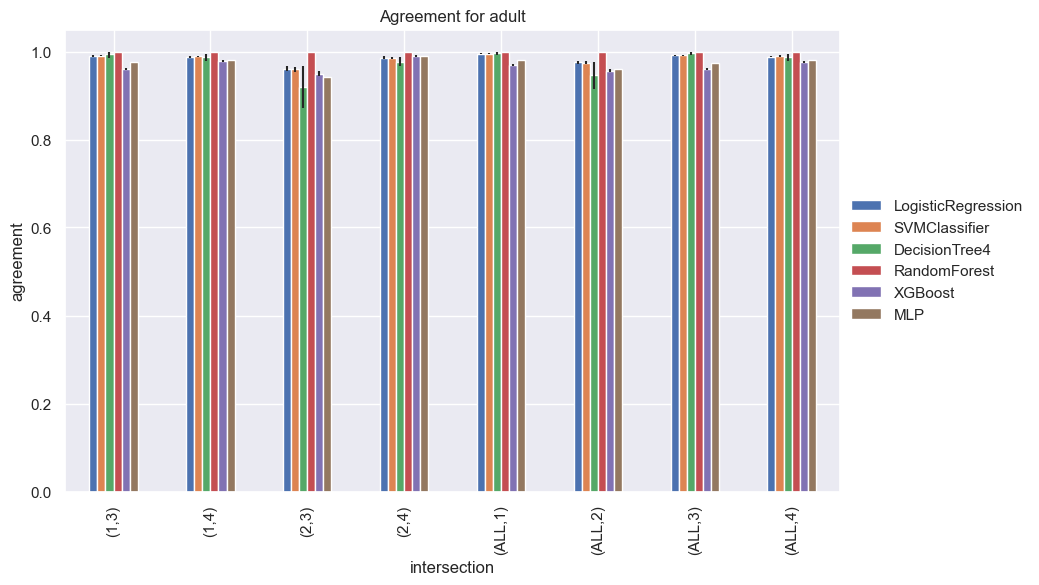

In [312]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'RandomForest',
    'XGBoost',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

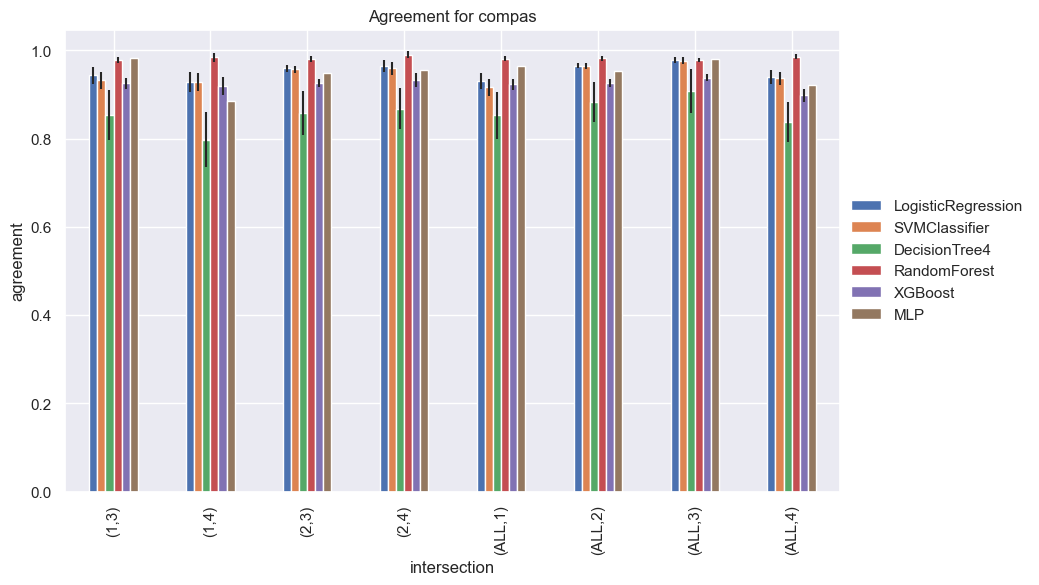

In [313]:
# Dataset: COMPAS
DATASET = 'compas'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'RandomForest',
    'XGBoost',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

KeyError: "('ALL',1)"

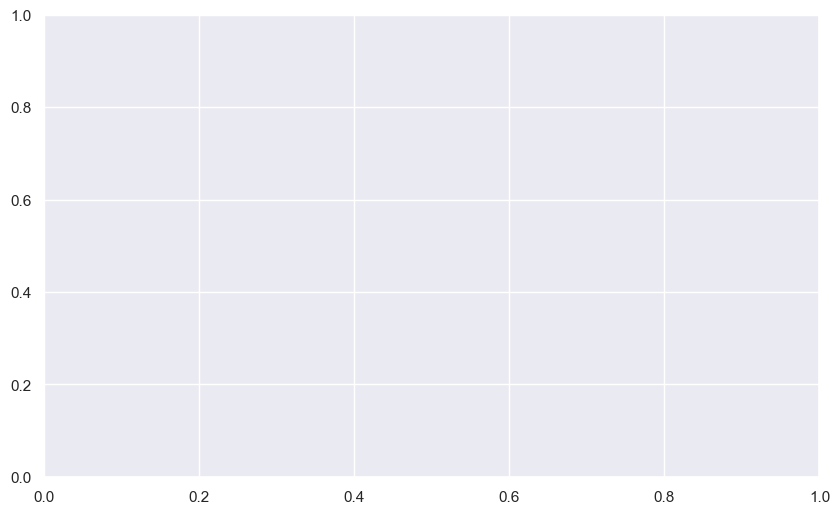

In [325]:
# Dataset: IncomeCA
DATASET = 'incomeCA'

models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'RandomForest',
    'XGBoost',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, ALL_INTERSECTIONS)
plt.show()